# References

GDS allows defining the component once in memory and reference to that structure in other components.

As you build complex components you can include references to other simpler components. Adding a reference is like having a pointer to a component.

The GDSII specification allows the use of references, and similarly gdsfactory uses them (with the `add_ref()` function).  So what is a reference? Simply put:  **A reference does not contain any geometry. It only *points* to an existing geometry**.

Say Alice has a ridiculously large polygon with 100 billion vertices in it that we'll call BigPolygon. It's huge, and she needs to use it in her design 250 times.  Well, a single copy of BigPolygon takes up 100GB of memory just by itself, so she doesn't want to make 250 copies of it. Since Alice is clever, she instead *references* the polygon 250 times.  Each reference only uses a few bytes of memory -- it only needs to know the memory address of BigPolygon and a few other things. In this way, she can keep one copy of BigPolygon and use it again and again wherever she needs to.


Let's start by making a blank geometry (`Component`) then adding a single polygon to it.

2022-04-27 17:27:51.720 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.2.7


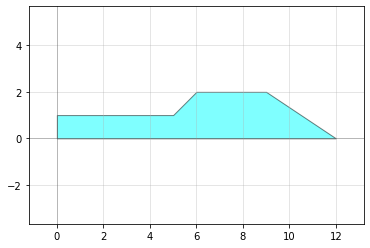

In [1]:
import numpy as np
import gdsfactory as gf

gf.config.set_plot_options(show_subports=False)
# gf.CONF.plotter = 'holoviews'

# Create a blank Component
p = gf.Component("component_with_polygon")

# Add a polygon
xpts = [0, 0, 5, 6, 9, 12]
ypts = [0, 1, 1, 2, 2, 0]
p.add_polygon([xpts, ypts], layer=(2, 0))

# plot the Component with the polygon in it
p.plot()

Now, pretend we're in the same position as Alice: We want to reuse this polygon
repeatedly but do not want to make multiple copies of it.  To do so, we need to
make a second blank `Component`, this time called `c`.  In this new Component we'll
*reference* our Component `p` which contains our polygon.

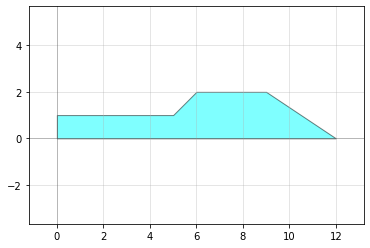

In [2]:
c = gf.Component("Component_with_references")  # Create a new blank Component
poly_ref = c.add_ref(p)  # Reference the Component "p" that has the polygon in it
c.show()  # show it in klayout
c.plot()  # plot the reference-containing Component "c"

OK, well that seemed to work, but it also seems thoroughly useless!  It looks
like you just made a copy of your polygon -- but remember, you didn't actually
make a second polygon, you just made a reference (aka pointer) to the original
polygon.  Let's add two more references to `c`:

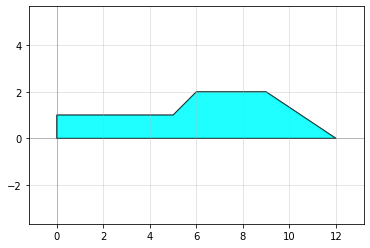

In [3]:
poly_ref2 = c.add_ref(p)  # Reference the Component "p" that has the polygon in it
poly_ref3 = c.add_ref(p)  # Reference the Component "p" that has the polygon in it

c.show()
c.plot()  # plot the reference-containing Component "c"

Now you have 3x polygons all on top of each other.  Again, this would appear
useless, except that you can manipulate each reference indepedently. Notice that
when you called `c.add_ref(p)` above, we saved the result to a new variable each
time (`poly_ref`, `poly_ref2`, and `poly_ref3`)?  You can use those variables to
reposition the references.

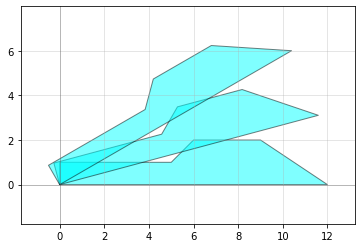

In [4]:
poly_ref2.rotate(15)  # Rotate the 2nd reference we made 15 degrees
poly_ref3.rotate(30)  # Rotate the 3rd reference we made 30 degrees
c.show()
c.plot()

Now you're getting somewhere! You've only had to make the polygon once, but you're
able to reuse it as many times as you want.

## Modifying the referenced geometry

What happens when you change the original geometry that the reference points to?  In your case, your references in
`c` all point to the Component `p` that with the original polygon.  Let's try
adding a second polygon to `p`.

First you add the second polygon and make sure `P` looks like you expect:

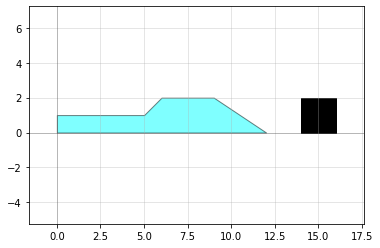

In [5]:
# Add a 2nd polygon to "p"
xpts = [14, 14, 16, 16]
ypts = [0, 2, 2, 0]
p.add_polygon([xpts, ypts], layer=(1, 0))
p.plot()

That looks good.  Now let's find out what happened to `c` that contains the
three references.  Keep in mind that you have not modified `c` or executed any
functions/operations on `c` -- all you have done is modify `p`.

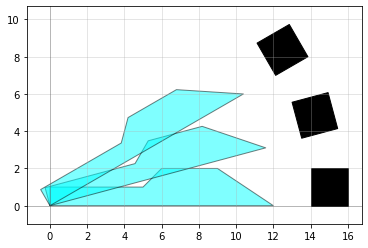

In [6]:
c.plot()

 **When you modify the original geometry, all of the
references automatically reflect the modifications.**  This is very powerful,
because you can use this to make very complicated designs from relatively simple
elements in a computation- and memory-efficienct way.

Let's try making references a level deeper by referencing `c`.  Note here we use
the `<<` operator to add the references -- this is just shorthand, and is
exactly equivalent to using `add_ref()`

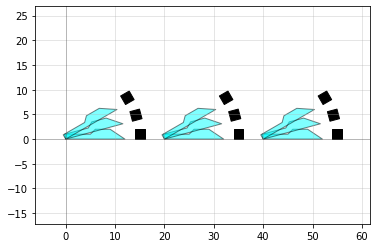

In [7]:
c2 = gf.Component()  # Create a new blank Component
d_ref1 = c2.add_ref(c)  # Reference the Component "c" that 3 references in it
d_ref2 = c2 << c  # Use the "<<" operator to create a 2nd reference to c
d_ref3 = c2 << c  # Use the "<<" operator to create a 3rd reference to c

d_ref1.move([20, 0])
d_ref2.move([40, 0])

c2.plot()

As you've seen you have two ways to add a reference to our component:

1. create the reference and add it to the component

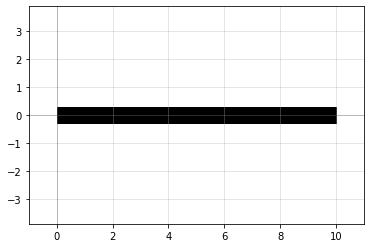

In [8]:
c = gf.Component("reference_sample")
w = gf.components.straight(width=0.6)
wr = w.ref()
c.add(wr)
c.plot()

2. or do it in a single line

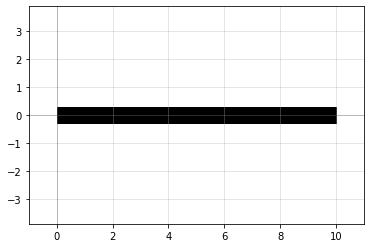

In [9]:
c = gf.Component("reference_sample_shorter_syntax")
wr = c << gf.components.straight(width=0.6)
c.plot()

in both cases you can move the reference `wr` after created

In [10]:
import gdsfactory as gf

c = gf.Component("two_references")
wr1 = c << gf.components.straight(width=0.6)
wr2 = c << gf.components.straight(width=0.6)
wr2.movey(10)
c.add_ports(wr1.get_ports_list(), prefix="top_")
c.add_ports(wr2.get_ports_list(), prefix="bot_")

In [11]:
c.ports

{'top_o1': Port (name top_o1, midpoint [0. 0.], width 0.6, orientation 180, layer (1, 0), port_type optical),
 'top_o2': Port (name top_o2, midpoint [10.  0.], width 0.6, orientation 0.0, layer (1, 0), port_type optical),
 'bot_o1': Port (name bot_o1, midpoint [ 0. 10.], width 0.6, orientation 180, layer (1, 0), port_type optical),
 'bot_o2': Port (name bot_o2, midpoint [10. 10.], width 0.6, orientation 0.0, layer (1, 0), port_type optical)}

You can also auto_rename ports using gdsfactory default convention, where ports are numbered clockwise starting from the bottom left

In [12]:
c.auto_rename_ports()

In [13]:
c.ports

{'o1': Port (name o1, midpoint [0. 0.], width 0.6, orientation 180, layer (1, 0), port_type optical),
 'o4': Port (name o4, midpoint [10.  0.], width 0.6, orientation 0.0, layer (1, 0), port_type optical),
 'o2': Port (name o2, midpoint [ 0. 10.], width 0.6, orientation 180, layer (1, 0), port_type optical),
 'o3': Port (name o3, midpoint [10. 10.], width 0.6, orientation 0.0, layer (1, 0), port_type optical)}

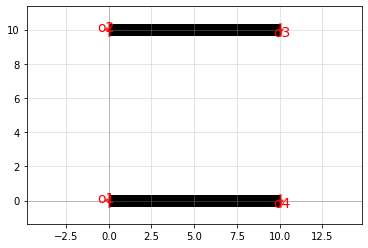

In [14]:
c.plot()

## Arrays of references

In GDS, there's a type of structure called a "CellArray" which takes a cell and repeats it NxM times on a fixed grid spacing. For convenience, `Component` includes this functionality with the add_array() function.
Note that CellArrays are not compatible with ports (since there is no way to access/modify individual elements in a GDS cellarray)

gdsfactory also provides with more flexible arrangement options if desired, see for example `grid()` and `packer()`.

As well as `gf.components.array`

Let's make a new Component and put a big array of our Component `c` in it:

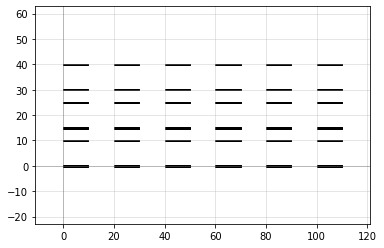

In [15]:
c3 = gf.Component()  # Create a new blank Component
aref = c3.add_array(
    c, columns=6, rows=3, spacing=[20, 15]
)  # Reference the Component "c" 3 references in it with a 3 rows, 6 columns array
c3.plot()

CellArrays don't have ports and there is no way to access/modify individual elements in a GDS cellarray.

gdsfactory provides you with similar functions in `gf.components.array` and `gf.components.array_2d`

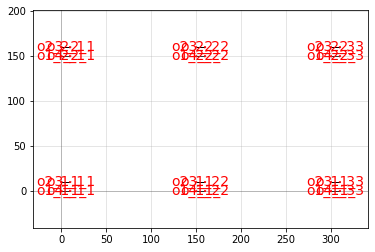

In [16]:
c4 = gf.Component()  # Create a new blank Component
aref = c4 << gf.components.array(component=c, columns=3, rows=2)
c4.add_ports(aref.get_ports_list())
c4.plot()

In [17]:
gf.components.array?

You can also create an array of references for periodic structures. Lets create a [Distributed Bragg Reflector](https://picwriter.readthedocs.io/en/latest/components/dbr.html)


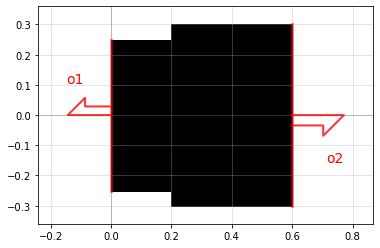

In [18]:
import gdsfactory as gf


@gf.cell
def dbr_period(w1=0.5, w2=0.6, l1=0.2, l2=0.4, straight=gf.components.straight):
    """Return one DBR period."""
    c = gf.Component()
    r1 = c << straight(length=l1, width=w1)
    r2 = c << straight(length=l2, width=w2)
    r2.connect(port="o1", destination=r1.ports["o2"])
    c.add_port("o1", port=r1.ports["o1"])
    c.add_port("o2", port=r2.ports["o2"])
    return c


l1 = 0.2
l2 = 0.4
n = 3
period = dbr_period(l1=l1, l2=l2)
period.plot()

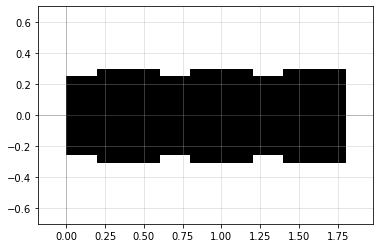

In [19]:
dbr = gf.Component("DBR")
dbr.add_array(period, columns=n, rows=1, spacing=(l1 + l2, 100))
dbr.plot()

Finally we need to add ports to the new component

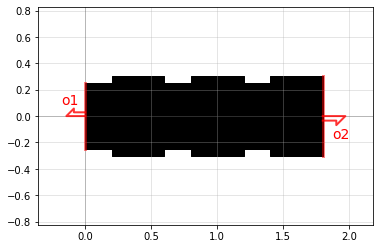

In [20]:
p0 = dbr.add_port("o1", port=period.ports["o1"])
p1 = dbr.add_port("o2", port=period.ports["o2"])

p1.midpoint = [(l1 + l2) * n, 0]
dbr.plot()

## Connect references

We have seen that once you create a reference you can manipulate the reference to move it to a location. Here we are going to connect that reference to a port. Remeber that we follow that a certain reference `source` connects to a `destination` port

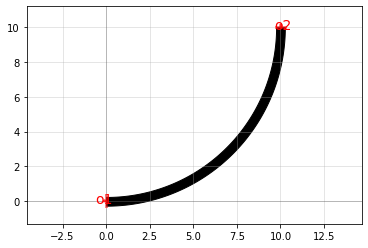

In [21]:
bend = gf.components.bend_circular()
bend.plot()

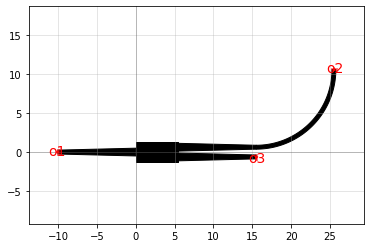

In [22]:
c = gf.Component("sample_reference_connect")

mmi = c << gf.components.mmi1x2()
b = c << gf.components.bend_circular()
b.connect("o1", destination=mmi.ports["o2"])

c.add_port("o1", port=mmi.ports["o1"])
c.add_port("o2", port=b.ports["o2"])
c.add_port("o3", port=mmi.ports["o3"])
c.plot()

## Port naming

You have the freedom to name the ports as you want, and you can use `gf.port.auto_rename_ports(prefix='o')` to rename them later on.

Here is the default naming convention.

Ports are numbered clock-wise starting from the bottom left corner

Optical ports have `o` prefix and Electrical ports `e` prefix

The port naming comes in most cases from the `gdsfactory.cross_section`. For example

- `gdsfactory.cross_section.strip`  has ports `o1` for input and `o2` for output
- `gdsfactory.cross_section.metal1` has ports `e1` for input and `e2` for output

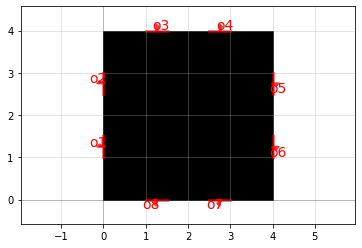

In [23]:
import gdsfactory as gf

size = 4
c = gf.components.nxn(west=2, south=2, north=2, east=2, xsize=size, ysize=size)
c.plot()

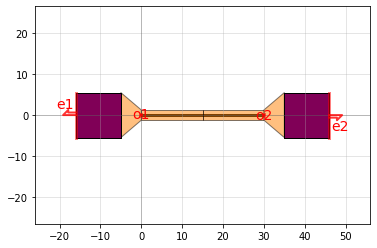

In [24]:
c = gf.components.straight_heater_metal(length=30)
c.plot()

In [25]:
c.ports

{'o1': Port (name o1, midpoint [0. 0.], width 0.5, orientation 180, layer (1, 0), port_type optical),
 'o2': Port (name o2, midpoint [30.  0.], width 0.5, orientation 0.0, layer (1, 0), port_type optical),
 'e1': Port (name e1, midpoint [-16.   0.], width 11.0, orientation 180, layer (49, 0), port_type electrical),
 'e2': Port (name e2, midpoint [46.  0.], width 11.0, orientation 0, layer (49, 0), port_type electrical)}

You can get the optical ports by `layer`

In [26]:
c.get_ports_dict(layer=(1, 0))

{'o1': Port (name o1, midpoint [0. 0.], width 0.5, orientation 180, layer (1, 0), port_type optical),
 'o2': Port (name o2, midpoint [30.  0.], width 0.5, orientation 0.0, layer (1, 0), port_type optical)}

or by `width`

In [27]:
c.get_ports_dict(width=0.5)

{'o1': Port (name o1, midpoint [0. 0.], width 0.5, orientation 180, layer (1, 0), port_type optical),
 'o2': Port (name o2, midpoint [30.  0.], width 0.5, orientation 0.0, layer (1, 0), port_type optical)}

In [28]:
c0 = gf.components.straight_heater_metal()
c0.ports

{'o1': Port (name o1, midpoint [0. 0.], width 0.5, orientation 180, layer (1, 0), port_type optical),
 'o2': Port (name o2, midpoint [320.   0.], width 0.5, orientation 0.0, layer (1, 0), port_type optical),
 'e1': Port (name e1, midpoint [-16.   0.], width 11.0, orientation 180, layer (49, 0), port_type electrical),
 'e2': Port (name e2, midpoint [336.   0.], width 11.0, orientation 0, layer (49, 0), port_type electrical)}

In [29]:
c1 = c0.copy()
c1.auto_rename_ports_layer_orientation()
c1.ports

{'1_0_W0': Port (name 49_0_W1, midpoint [0. 0.], width 0.5, orientation 180, layer (1, 0), port_type optical),
 '1_0_E0': Port (name 49_0_E0, midpoint [320.   0.], width 0.5, orientation 0.0, layer (1, 0), port_type optical),
 '49_0_W0': Port (name 49_0_W0, midpoint [-16.   0.], width 11.0, orientation 180, layer (49, 0), port_type electrical),
 '49_0_E1': Port (name 49_0_E1, midpoint [336.   0.], width 11.0, orientation 0, layer (49, 0), port_type electrical)}

In [30]:
c2 = c0.copy()
c2.auto_rename_ports()
c2.ports

{'o1': Port (name o1, midpoint [0. 0.], width 0.5, orientation 180, layer (1, 0), port_type optical),
 'o2': Port (name o2, midpoint [320.   0.], width 0.5, orientation 0.0, layer (1, 0), port_type optical),
 'e1': Port (name e1, midpoint [-16.   0.], width 11.0, orientation 180, layer (49, 0), port_type electrical),
 'e2': Port (name e2, midpoint [336.   0.], width 11.0, orientation 0, layer (49, 0), port_type electrical)}

You can also rename them with a different port naming convention

- prefix: add `e` for electrical `o` for optical
- clockwise
- counter-clockwise
- orientation `E` East, `W` West, `N` North, `S` South


Here is the default one we use (clockwise starting from bottom left west facing port)

```
             3   4
             |___|_
         2 -|      |- 5
            |      |
         1 -|______|- 6
             |   |
             8   7

```

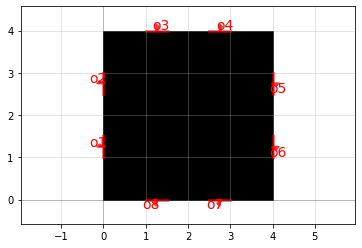

In [31]:
import gdsfactory as gf

c = gf.Component()
nxn = gf.components.nxn(west=2, north=2, east=2, south=2, xsize=4, ysize=4)
ref = c.add_ref(nxn)
c.add_ports(ref.ports)
c.plot()

In [32]:
ref.get_ports_list()  # by default returns ports clockwise starting from bottom left west facing port

[Port (name o1, midpoint [0.   1.25], width 0.5, orientation 180, layer (1, 0), port_type optical),
 Port (name o2, midpoint [0.   2.75], width 0.5, orientation 180, layer (1, 0), port_type optical),
 Port (name o3, midpoint [1.25 4.  ], width 0.5, orientation 90, layer (1, 0), port_type optical),
 Port (name o4, midpoint [2.75 4.  ], width 0.5, orientation 90, layer (1, 0), port_type optical),
 Port (name o5, midpoint [4.   2.75], width 0.5, orientation 0, layer (1, 0), port_type optical),
 Port (name o6, midpoint [4.   1.25], width 0.5, orientation 0, layer (1, 0), port_type optical),
 Port (name o7, midpoint [2.75 0.  ], width 0.5, orientation 270, layer (1, 0), port_type optical),
 Port (name o8, midpoint [1.25 0.  ], width 0.5, orientation 270, layer (1, 0), port_type optical)]

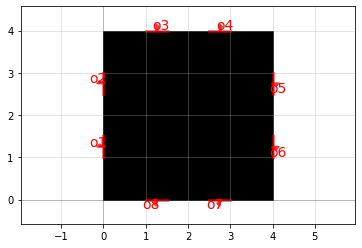

In [33]:
c.auto_rename_ports()
c.plot()

You can also get the ports counter-clockwise

```
             4   3
             |___|_
         5 -|      |- 2
            |      |
         6 -|______|- 1
             |   |
             7   8

```

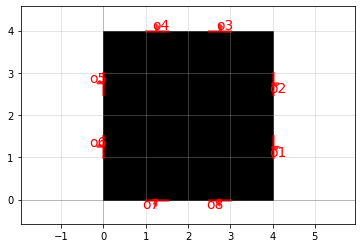

In [34]:
c.auto_rename_ports_counter_clockwise()
c.plot()

In [35]:
c.get_ports_list(clockwise=False)

[Port (name o1, midpoint [4.   1.25], width 0.5, orientation 0, layer (1, 0), port_type optical),
 Port (name o2, midpoint [4.   2.75], width 0.5, orientation 0, layer (1, 0), port_type optical),
 Port (name o3, midpoint [2.75 4.  ], width 0.5, orientation 90, layer (1, 0), port_type optical),
 Port (name o4, midpoint [1.25 4.  ], width 0.5, orientation 90, layer (1, 0), port_type optical),
 Port (name o5, midpoint [0.   2.75], width 0.5, orientation 180, layer (1, 0), port_type optical),
 Port (name o6, midpoint [0.   1.25], width 0.5, orientation 180, layer (1, 0), port_type optical),
 Port (name o7, midpoint [1.25 0.  ], width 0.5, orientation 270, layer (1, 0), port_type optical),
 Port (name o8, midpoint [2.75 0.  ], width 0.5, orientation 270, layer (1, 0), port_type optical)]

In [36]:
c.ports_layer

{'1_0_W0': 'o6',
 '1_0_W1': 'o5',
 '1_0_E0': 'o1',
 '1_0_E1': 'o2',
 '1_0_N0': 'o4',
 '1_0_N1': 'o3',
 '1_0_S0': 'o7',
 '1_0_S1': 'o8'}

In [37]:
c.port_by_orientation_cw("W0")

Port (name o6, midpoint [0.   1.25], width 0.5, orientation 180, layer (1, 0), port_type optical)

In [38]:
c.port_by_orientation_ccw("W1")

Port (name o6, midpoint [0.   1.25], width 0.5, orientation 180, layer (1, 0), port_type optical)

Lets extend the East facing ports (orientation = 0 deg)

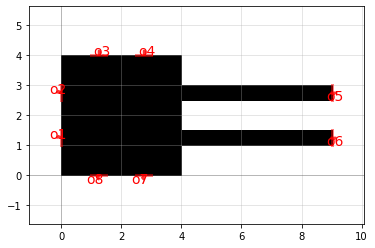

In [39]:
import gdsfactory as gf

nxn = gf.components.nxn(
    west=2,
    north=2,
    east=2,
    south=2,
    cross_section=gf.cross_section.strip,
    xsize=4,
    ysize=4,
)
c = gf.components.extension.extend_ports(component=nxn, orientation=0)
c.show()
c.plot()

In [40]:
c.ports

{'o1': Port (name o1, midpoint [0.   1.25], width 0.5, orientation 180, layer (1, 0), port_type optical),
 'o2': Port (name o2, midpoint [0.   2.75], width 0.5, orientation 180, layer (1, 0), port_type optical),
 'o3': Port (name o3, midpoint [1.25 4.  ], width 0.5, orientation 90, layer (1, 0), port_type optical),
 'o4': Port (name o4, midpoint [2.75 4.  ], width 0.5, orientation 90, layer (1, 0), port_type optical),
 'o5': Port (name o5, midpoint [9.   2.75], width 0.5, orientation 0.0, layer (1, 0), port_type optical),
 'o6': Port (name o6, midpoint [9.   1.25], width 0.5, orientation 0.0, layer (1, 0), port_type optical),
 'o7': Port (name o7, midpoint [2.75 0.  ], width 0.5, orientation 270, layer (1, 0), port_type optical),
 'o8': Port (name o8, midpoint [1.25 0.  ], width 0.5, orientation 270, layer (1, 0), port_type optical)}

## component_sequence

When you have repetitive connections you can describe the connectivity as an ASCII map

In [41]:
import gdsfactory as gf

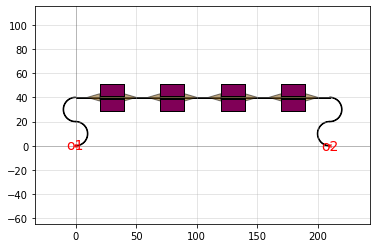

In [42]:
bend180 = gf.components.bend_circular180()
wg_pin = gf.components.straight_pin(length=40)
wg = gf.components.straight()

# Define a map between symbols and (component, input port, output port)
symbol_to_component = {
    "D": (bend180, "o1", "o2"),
    "C": (bend180, "o2", "o1"),
    "P": (wg_pin, "o1", "o2"),
    "-": (wg, "o1", "o2"),
}

# Generate a sequence
# This is simply a chain of characters. Each of them represents a component
# with a given input and and a given output

sequence = "DC-P-P-P-P-CD"
component = gf.components.component_sequence(
    sequence=sequence, symbol_to_component=symbol_to_component
)
component.name = "component_sequence"
component.show()
component.plot()

As the sequence is defined as a string you can use the string operations to easily build complex sequences